In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
model = torchvision.models.vgg16(pretrained=True).eval()
sumie.utils.remove_inplace(model)
sumie.utils.max_to_avg_pool(model)
#model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU()
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1,

100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


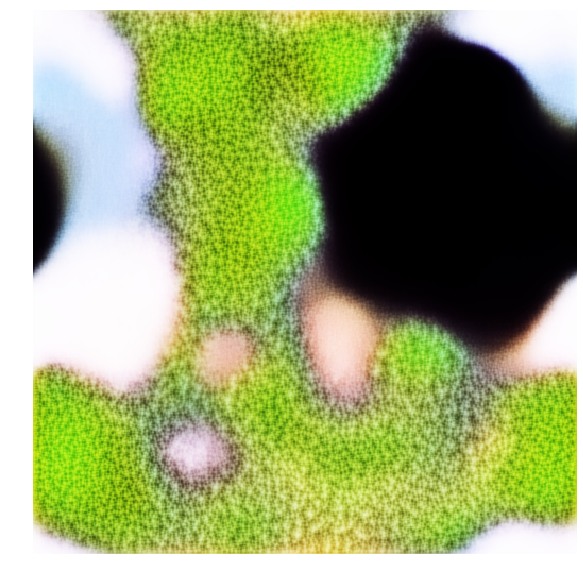

In [33]:
def normalise(image):
    
        mean = torch.as_tensor([0.485, 0.456, 0.406])
        std = torch.as_tensor([0.229, 0.224, 0.225])
        return (image - mean[None,:,None,None]) /std[None,:,None,None]

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Piper_betle_plant.jpg/320px-Piper_betle_plant.jpg'
imsize = 512
base_image = sumie.io.load_url(url, size=(imsize, imsize))
base_image = normalise(base_image)

im = sumie.Image(imsize, param='fft', transforms=[
                    #sumie.transforms.PositionJitter(8),
                    sumie.transforms.Normalise(),
              ])

device = 'cuda'
im.to(device)
model.to(device)

content = sumie.objectives.Style(base_image.to(device), model.features, [model.features[3],])

opt = sumie.Optimiser(im, model.features, content)
opt.run(iterations=200, lr=0.1, progress=True)
sumie.vis.show(im.get_image(), figsize = (10, 10))

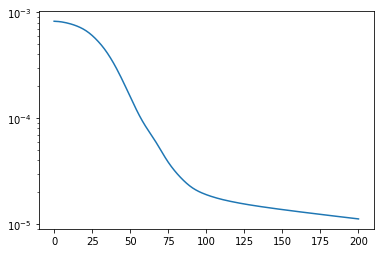

In [36]:
plt.semilogy([-1*x.item() for x in opt.history])

100%|██████████| 200/200 [00:22<00:00,  8.69it/s]


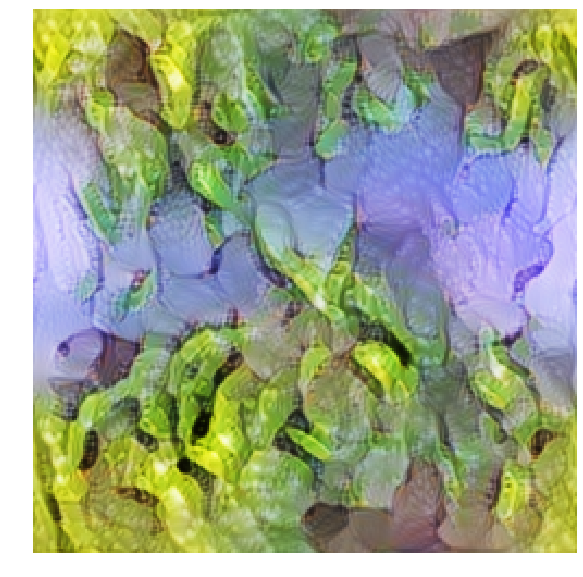

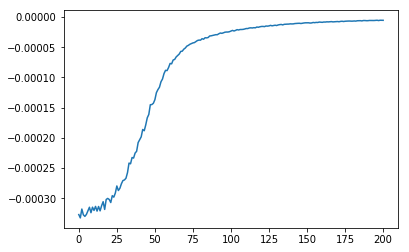

In [8]:
class CompositeImage(torch.nn.Module):
    
    def __init__(self, im1, im2, transforms):
        super(CompositeImage, self).__init__()
        self.im1 = im1
        self.im2 = im2
        self.transforms = torch.nn.Sequential(*transforms)
        
    def forward(self):
        batched = torch.cat((self.im1(), self.im2))
        return self.transforms(batched)

imsize = 250
base_image = sumie.io.load_url(url, size=(imsize, imsize))
im = sumie.Image(imsize, param='fft', transforms=[])

device = 'cuda'
im.to(device)
model.to(device)

combined_im = CompositeImage(im, base_image.to(device), 
                             [
                    sumie.transforms.PositionJitter(8),
                    sumie.transforms.Normalise(),
                             ])
combined_im.to(device)
content = sumie.objectives.BatchMatchActivations(model.features[10], 0, 1, func=lambda x: sumie.utils.gram_matrix(x.unsqueeze(0)))

opt = sumie.Optimiser(combined_im, model.features, content)
opt.run(iterations=100, lr=0.05, progress=True)
sumie.vis.show(im.get_image(), figsize = (10, 10))
plt.plot([x.item() for x in opt.history])